In [1]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpyro
numpyro.set_host_device_count(8)

import numpy as np
from jax import numpy as jnp
from jax import random
from tqdm import trange
from numpyro import plate, sample, factor, deterministic
from numpyro.distributions import Normal, Uniform, TruncatedNormal
from numpyro.infer import MCMC, NUTS, init_to_median
from corner import corner

import matplotlib.pyplot as plt
import scienceplots

from scipy.stats import norm
import candel

SPEED_OF_LIGHT = candel.SPEED_OF_LIGHT

In [2]:
def r2mu(r):
    return 5 * jnp.log10(r) + 25

def mu2r(mu):
    return 10**((mu - 25) / 5)

def r2czcosmo(r, H0=70):
    return r * H0

In [3]:
def make_mock(H0, a_TFR, b_TFR, sigma_TFR, sigma_v, Rmax, mean_eta_true,
              std_eta_true, e_eta, e_mag, npoints, seed, mag_lim=None):
    gen = np.random.default_rng(seed)

    r = Rmax * gen.uniform(0, 1, npoints)**(1/3)
    mu = r2mu(r)

    eta_true = gen.normal(mean_eta_true, std_eta_true, npoints)

    eta_obs = gen.normal(eta_true, e_eta)

    M = gen.normal(a_TFR + b_TFR * eta_true, sigma_TFR, )

    mag_obs = gen.normal(mu + M, e_mag)
    cz = gen.normal(r2czcosmo(r, H0=H0), sigma_v)

    data = {"eta_obs": eta_obs,
            "mag_obs": mag_obs,
            "cz_obs": cz,
            "r": r,
            }
    
    mask = np.ones(npoints, dtype=bool)
    if mag_lim is not None:
        mask = mask & (mag_obs < mag_lim)
    
    data = {k: v[mask] for k, v in data.items()}
    return data


Mock with 101 points created.


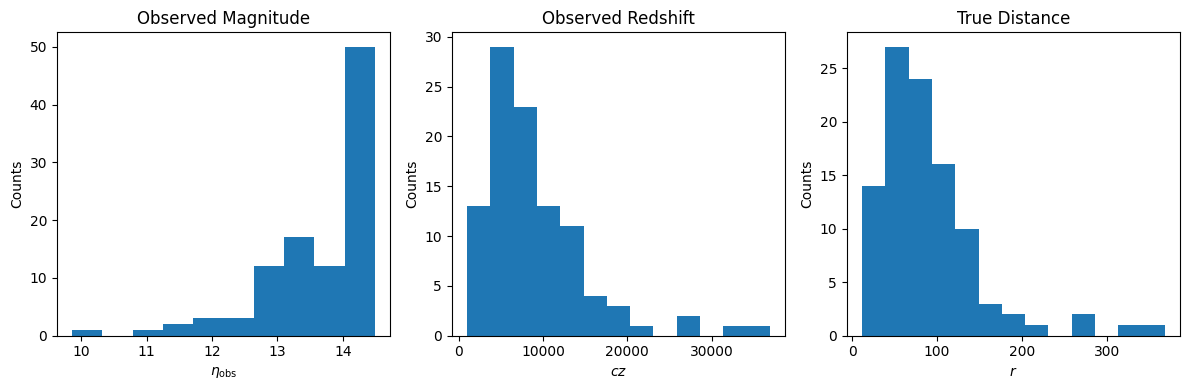

In [4]:
mock_kwargs = dict(H0=100, a_TFR=-19, b_TFR=-7, sigma_TFR=0.25, sigma_v=250,
                   Rmax=500, mean_eta_true=0, std_eta_true=0.15, e_eta=0.05, e_mag=0.05,
                   npoints=30000, seed=42, mag_lim=14.5)


mock = make_mock(**mock_kwargs)

print(f"Mock with {mock['r'].size} points created.")

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)

axes[0].hist(mock["mag_obs"], bins="auto")
axes[0].set_xlabel(r'$\eta_\mathrm{obs}$')
axes[0].set_title('Observed Magnitude')

axes[1].hist(mock["cz_obs"], bins="auto")
axes[1].set_xlabel(r'$cz$')
axes[1].set_title('Observed Redshift')

axes[2].hist(mock["r"], bins="auto")
axes[2].set_xlabel(r'$r$')
axes[2].set_title('True Distance')

for ax in axes:
    ax.set_ylabel('Counts')

plt.tight_layout()
plt.show()

In [10]:
def model(eta_obs, mag_obs, cz_obs, e_eta, e_mag, Rmax, mean_eta_true=None, std_eta_true=None, sigma_v=None, H0=70):
    npoints = len(eta_obs)

    if mean_eta_true is None:
        mean_eta_true = sample("mean_eta_true", Uniform(-4, 4))

    if std_eta_true is None:
        std_eta_true = sample("std_eta_true", Uniform(0, 1))
        factor("ll_std_eta_true", - jnp.log(std_eta_true))

    a_TFR = sample("a_TFR", Normal(-22, 0.5))
    b_TFR = sample("b_TFR", Normal(-7, 0.5))
    sigma_TFR = sample("sigma_TFR", Uniform(0, 1))
    factor("ll_sigma_TFR", - jnp.log(sigma_TFR))

    if sigma_v is None:
        sigma_v = sample("sigma_v", Uniform(0, 500))
        factor("ll_sigma_v", - jnp.log(sigma_v))
    
    factor("neg_ll_S", -npoints * jnp.log(10**(3 / 5 * a_TFR)))

    with plate("plate_eta_true", npoints):
        eta_true = sample("eta_true", Normal(mean_eta_true, std_eta_true))
        factor("ll_eta_obs", Normal(eta_true, e_eta).log_prob(eta_obs))

        M = sample("M", Normal(a_TFR + b_TFR * eta_true, sigma_TFR))

        r = sample("r", Uniform(0, Rmax))
        factor("ll_r", 2 * jnp.log(3) - 3 * jnp.log(Rmax))

        mag = r2mu(r) + M
        sample("mag_obs", Normal(mag, e_mag), obs=mag_obs)

        cz = r2czcosmo(r, H0)
        sample("cz_obs", Normal(cz, sigma_v), obs=cz_obs)



In [11]:
num_warmup = 250
num_samples = 1000
num_chains = 8
progress_bar = True

mock = make_mock(**mock_kwargs)

kernel = NUTS(model, init_strategy=init_to_median(num_samples=2500))
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples,
            num_chains=num_chains, progress_bar=progress_bar)
mcmc.run(
    random.PRNGKey(0),
    eta_obs=jnp.asarray(mock["eta_obs"]),
    mag_obs=jnp.asarray(mock["mag_obs"]),
    cz_obs=jnp.asarray(mock["cz_obs"]),
    e_eta=mock_kwargs["e_eta"],
    e_mag=mock_kwargs["e_mag"],
    Rmax=mock_kwargs["Rmax"],
    mean_eta_true=mock_kwargs["mean_eta_true"],
    std_eta_true=mock_kwargs["std_eta_true"],
    sigma_v=mock_kwargs["sigma_v"],
    H0=mock_kwargs["H0"],
)

mcmc.print_summary()
samples = mcmc.get_samples()

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
         M[0]    -20.52      0.07    -20.52    -20.64    -20.40  16997.26      1.00
         M[1]    -22.32      0.06    -22.32    -22.41    -22.23  15889.61      1.00
         M[2]    -20.81      0.07    -20.82    -20.93    -20.70  15889.57      1.00
         M[3]    -20.81      0.10    -20.81    -20.98    -20.64  10574.35      1.00
         M[4]    -19.60      0.10    -19.61    -19.76    -19.45  15476.92      1.00
         M[5]    -19.53      0.14    -19.53    -19.77    -19.30  11376.03      1.00
         M[6]    -22.08      0.06    -22.08    -22.17    -21.98  15093.64      1.00
         M[7]    -19.44      0.12    -19.44    -19.63    -19.25  15180.51      1.00
         M[8]    -22.68      0.05    -22.68    -22.77    -22.59  17370.99      1.00
         M[9]    -20.60      0.08    -20.60    -20.73    -20.47  13630.49      1.00
        M[10]    -20.57      0.12    -20.57    -20.77    -20.37  11551.68  

In [12]:
keys = ["a_TFR", "b_TFR", "sigma_TFR"]

X = np.vstack([samples[key] for key in keys]).T
truths = np.array([mock_kwargs[key] for key in keys])



/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_45462/183250905.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


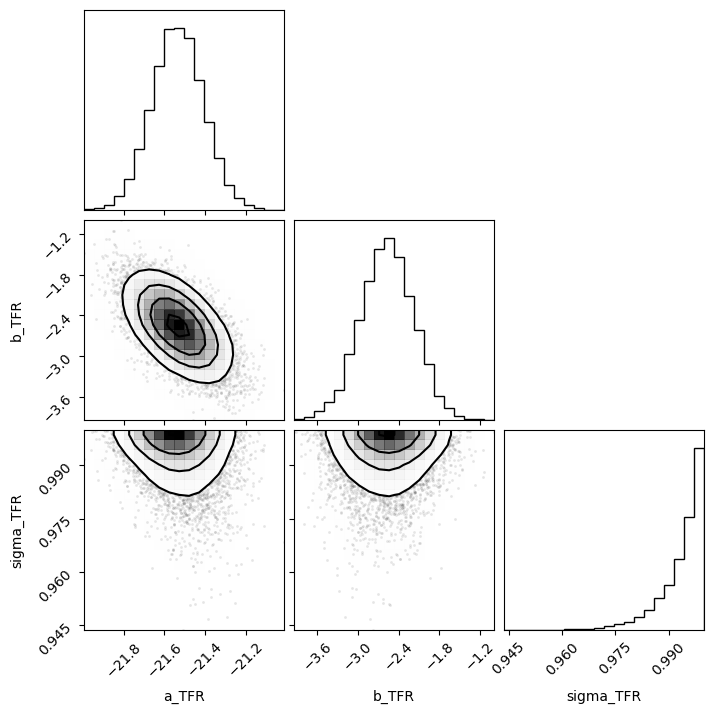

In [13]:
fig = corner(X, truths=truths, labels=keys,smooth=1)
fig.show()